# Import libraries

In [1]:
import pandas as pd

from src.constant import POSITIVE_NEGATIVE_MAP

from src.text_preprocessing import CleanText
from src.textual_information import (NumberOfCharactersPerReview,
                                     NumberOfWordsPerReview,
                                     AverageWordLengthPerReview)
from src.positive_negative_split import PositiveNegativeSplit
import src.helpers as helpers

from plot.plot_text import histplot, bar, tree
import plot.word_cloud as word_cloud
import seaborn as sns

from test.input_testing import is_pandas_series_of_lists, is_list_of_strings

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaheaal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yaheaal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/yaheaal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Read the data

In [2]:
df = pd.read_csv('data/IMDB Dataset.csv')

In [3]:
print(df.shape)
df.head()

(50000, 2)


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
df.drop_duplicates(inplace=True)

positive    24884
negative    24698
Name: sentiment, dtype: int64


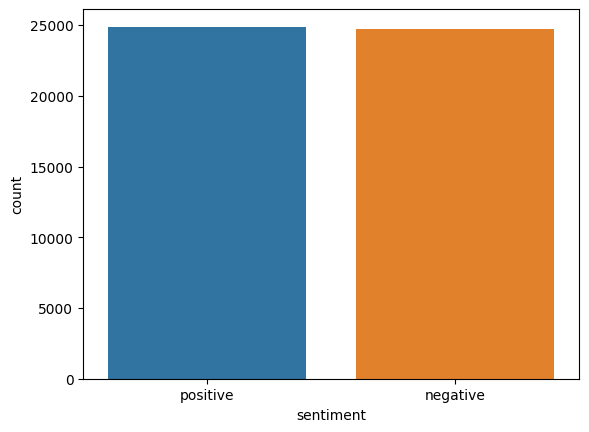

In [5]:
print(df['sentiment'].value_counts())
sns.countplot(data=df, x='sentiment');

# Clean the data

In [6]:
clean = CleanText(remove_html_tags=True,
                   make_all_lower=True,
                   clear_contractions=True,
                   remove_urls=True,
                   add_space_after_full_stop=True,
                   remove_punctuation=True,
                   tokenize=True,
                   remove_stop_words=True,
                   lemmatize=True)

Text preprocessing will be performed in this order
- HTML tags will be removed
- All uppercase characters will be converted into lowercase
- Contractions will be removed
- Urls will be removed
- Spaces will be added after full stop
- Punctuation will be removed
- Tokenizer will be implemented
- Stop words will be removed
- Lemmatizer will be implemented


In [7]:
df['clean_review'] = df['review'].apply(clean.clean)

/Users/yaheaal/Desktop/IMDB Sentiment Analysis /env/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [8]:
df['sentiment'].replace(POSITIVE_NEGATIVE_MAP, inplace=True)

# EDA

In [9]:
all_words = helpers.split_reviews_to_words(df['clean_review'])

top_words = helpers.top_n_words(all_words=all_words, n_words=10)
top_words = pd.DataFrame(top_words, columns=['corpus','count'])
top_words

corpus  count
0        one  53524
1       like  39739
2      would  30269
3       time  30088
4       good  28903
5  character  27798
6      story  24600
7       even  24435
8        get  24325
9        see  23516

In [10]:
bar(top_words, x='count', y='corpus', title='H-bar of most common words', color='corpus')

In [11]:
tree(data=top_words, path='corpus', values='count', title='Tree of Most common words')

In [12]:
positive_negative_split = PositiveNegativeSplit(data=df, text_column='clean_review', label_column='sentiment')

positive_reviews = positive_negative_split.split(sentiment='positive')
negative_reviews = positive_negative_split.split(sentiment='negative')

In [13]:
positive_reviews_str = helpers.series_lists_to_series_str(positive_reviews)
negative_reviews_str = helpers.series_lists_to_series_str(negative_reviews)

positive_reviews_str = helpers.series_str_to_one_str(positive_reviews_str)
negative_reviews_str = helpers.series_str_to_one_str(negative_reviews_str)

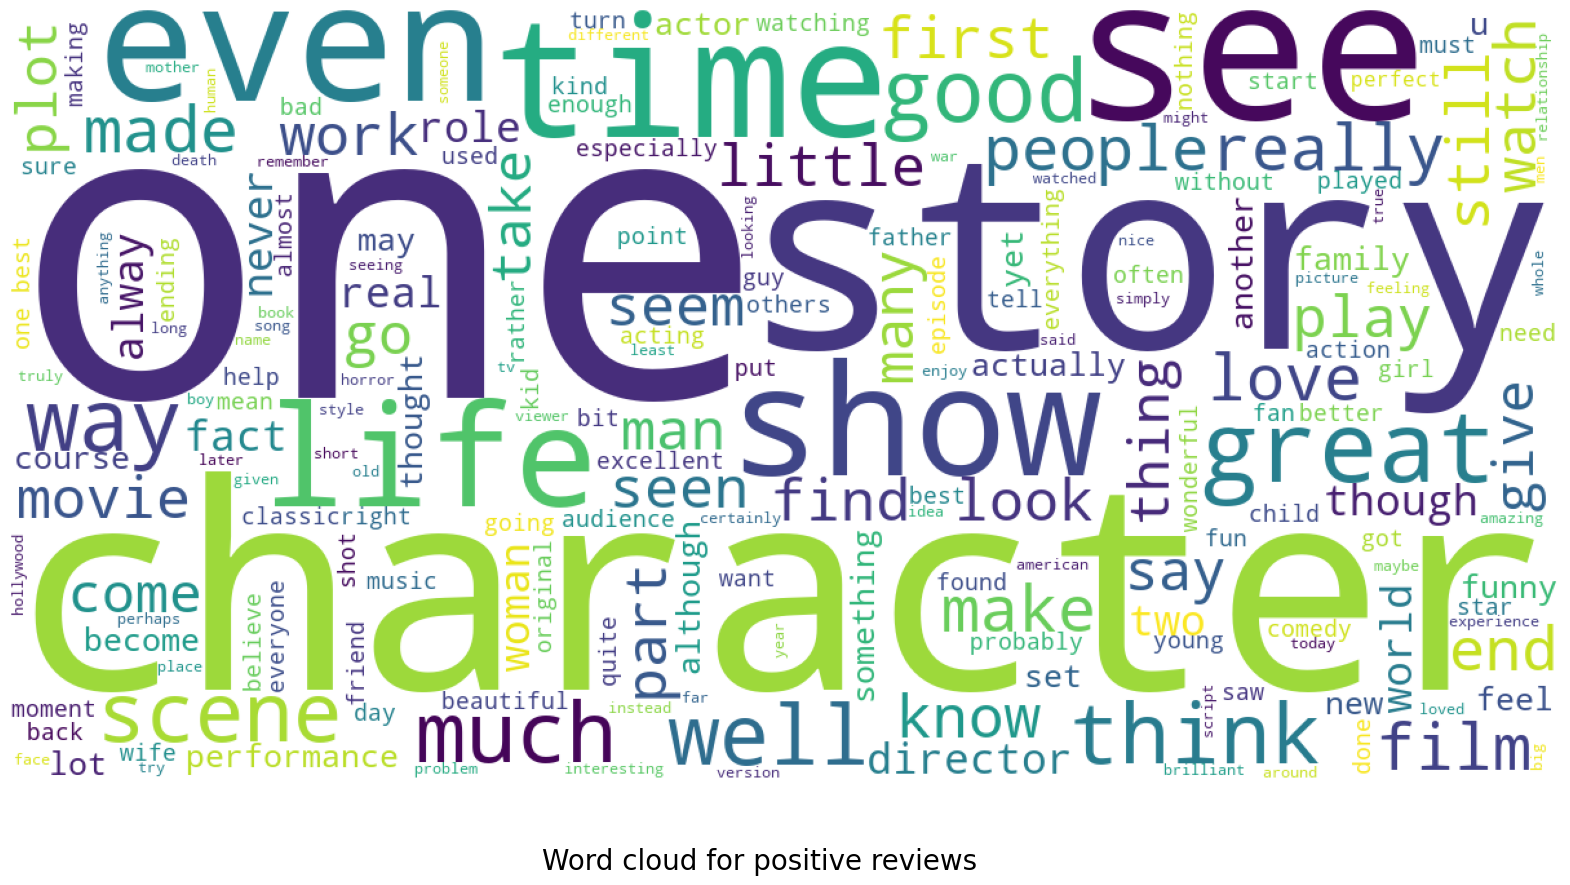

In [14]:
word_cloud.plot_wordcloud(positive_reviews_str, title='Word cloud for positive reviews')

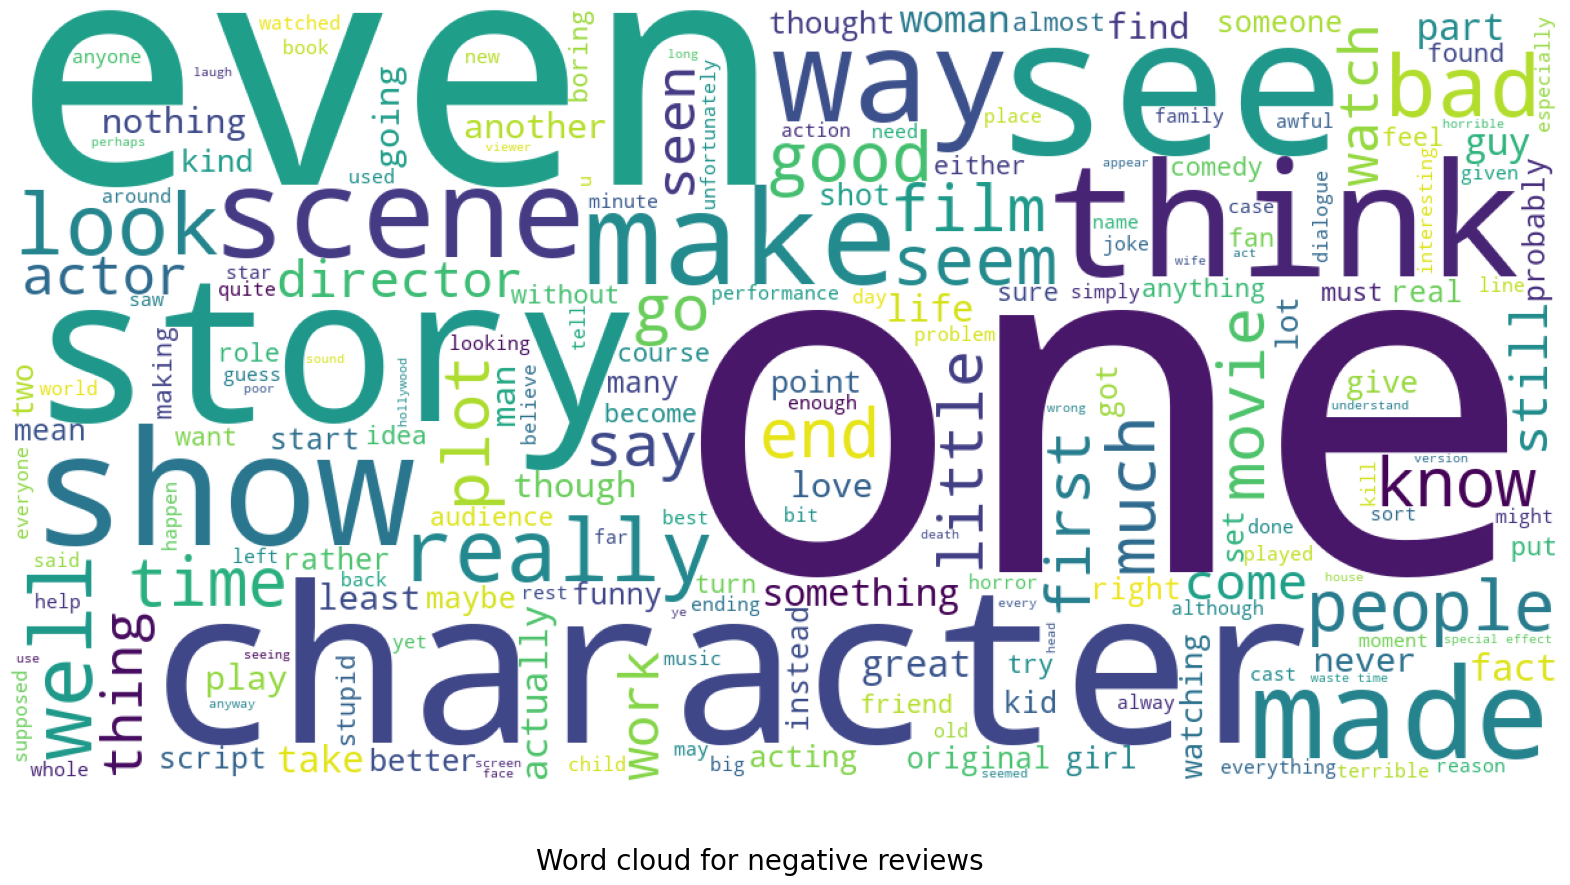

In [15]:
word_cloud.plot_wordcloud(negative_reviews_str, title='Word cloud for negative reviews')

In [16]:
number_of_positive_words = NumberOfWordsPerReview(positive_reviews)
number_of_negative_words = NumberOfWordsPerReview(negative_reviews)


histplot(number_of_positive_words.extract(),
        color='green',
        title='Number of words in positive reviews')

histplot(number_of_negative_words.extract(),
        color='red',
        title='Number of words in negative reviews')

In [17]:
number_of_positive_characters = NumberOfCharactersPerReview(positive_reviews)
number_of_negative_characters = NumberOfCharactersPerReview(negative_reviews)


histplot(number_of_positive_characters.extract(),
        color='green',
        title='Number of characters in positive reviews')

histplot(number_of_negative_characters.extract(),
        color='red',
        title='Number of characters in negative reviews')

In [18]:
positive_average_word_length = AverageWordLengthPerReview(positive_reviews)
negative_average_word_length = AverageWordLengthPerReview(negative_reviews)


histplot(positive_average_word_length.extract(),
        color='green',
        title='Average word length per positive review')

histplot(negative_average_word_length.extract(),
        color='red',
        title='Average word length per negative review')

# Machine learning for sentiment analysis

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [20]:
train, val = train_test_split(df, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train['review'], val['review'], train['sentiment'], val['sentiment']
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((39665,), (9917,), (39665,), (9917,))

In [21]:
tfidf = TfidfVectorizer()

In [22]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [23]:
lr = LogisticRegression()

lr.fit(X_train_tfidf, y_train)
pred=lr.predict(X_val_tfidf)

In [24]:
accuracy_score(y_val, pred)

0.8960371079963698